In [112]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast

import warnings
warnings.filterwarnings('ignore')

## CIFAR10

In [113]:
cifar10_classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [114]:
df = pd.read_csv('output/cifar10_decision_tree_metrics.csv', sep='\t')
df[:10]

,Index,GT Class,Pred Class,Path,Path Probs,Num Nodes Explored,Node Backtracks
0,0,3,3,"['n00003553', 'n01471682', 'n01886756', 'n0207...","[1.0, 1.0, 1.0, 1.0]",4,{}
1,1,8,8,"['n00003553', 'n03575240', 'n03125870']","[1.0, 1.0, 1.0]",3,{}
2,2,8,8,"['n00003553', 'n03575240', 'n03125870']","[1.0, 0.997, 0.9999]",3,{}
3,3,0,0,"['n00003553', 'n03575240', 'n03125870']","[0.9999, 0.9991, 0.991]",3,{}
4,4,6,6,"['n00003553', 'n01471682']","[1.0, 1.0]",2,{}
5,5,6,6,"['n00003553', 'n01471682']","[1.0, 1.0]",2,{}
6,6,1,1,"['n00003553', 'n03575240', 'n03791235']","[0.9999, 1.0, 0.9693]",3,{}
7,7,6,6,"['n00003553', 'n01471682']","[1.0, 1.0]",2,{}
8,8,3,3,"['n00003553', 'n01471682', 'n01886756', 'n0207...","[1.0, 1.0, 1.0, 1.0]",4,{}
9,9,1,1,"['n00003553', 'n03575240', 'n03791235']","[1.0, 1.0, 0.9998]",3,{}


### Preprocessing

In [115]:
df['Node Backtracks'] = df['Node Backtracks'].apply(lambda x: ast.literal_eval(x))
df['Path'] = df['Path'].apply(lambda x: ast.literal_eval(x))
df['Path Probs'] = df['Path Probs'].apply(lambda x: ast.literal_eval(x))
df['Num Backtracks'] = df["Node Backtracks"].apply(lambda x: type(x))

## Per class stats

In [116]:
class_stats = {"class":[], "name":[], "accuracy":[], "avg_path_len":[], "avg_backtracks":[], "target_path":[], "num_ignored":[], "incorrect_not_ignored":[], "backtrack_correct":[]}

In [117]:
for i in range(len(np.unique(df['GT Class']))):
    df['Num Backtracks'] = df["Node Backtracks"].apply(lambda x: len(x))
    class_df = df[df['GT Class']==i]
    class_stats["class"].append(i)
    class_stats["name"].append(cifar10_classes[i])
    class_stats["accuracy"].append(len(class_df[class_df['Pred Class']==i])/len(class_df))
    class_stats["avg_path_len"].append(np.mean(class_df["Num Nodes Explored"]))
    class_stats["avg_backtracks"].append(np.mean(class_df['Num Backtracks']))
    
    # find unique path
    gt_path = class_df[class_df['Pred Class']==i][class_df['Num Backtracks']==0]['Path']
    class_stats['target_path'].append(str(gt_path.iloc[0]))
    
    class_stats["num_ignored"].append(len(class_df[class_df['Pred Class']==-1]))
    class_stats["backtrack_correct"].append(len(class_df[class_df["Num Backtracks"]>0][class_df["Pred Class"] == i])/len(class_df[class_df["Num Backtracks"]>0]))
    
    incorrect = class_df[class_df['Pred Class']!=i]
    class_stats["incorrect_not_ignored"].append(len(incorrect[incorrect['Num Backtracks']!=0][incorrect["Index"]!=-1]))

In [120]:
stats = pd.DataFrame(class_stats)
stats[:10]

,class,name,accuracy,avg_path_len,avg_backtracks,target_path,num_ignored,incorrect_not_ignored,backtrack_correct
0,0,airplane,0.937,3.005,0.046,"['n00003553', 'n03575240', 'n03125870']",14,15,0.166667
1,1,automobile,0.968,3.007,0.015,"['n00003553', 'n03575240', 'n03791235']",4,4,0.200000
2,2,bird,0.920,2.122,0.020,"['n00003553', 'n01471682']",1,2,0.846154
3,3,cat,0.841,3.905,0.055,"['n00003553', 'n01471682', 'n01886756', 'n0207...",9,23,0.041667
4,4,deer,0.929,3.942,0.021,"['n00003553', 'n01471682', 'n01886756', 'n0237...",1,9,0.100000
5,5,dog,0.894,3.974,0.027,"['n00003553', 'n01471682', 'n01886756', 'n0207...",4,9,0.000000
6,6,frog,0.957,2.060,0.015,"['n00003553', 'n01471682']",1,4,0.500000
7,7,horse,0.936,3.987,0.048,"['n00003553', 'n01471682', 'n01886756', 'n0237...",8,18,0.052632
8,8,ship,0.965,3.008,0.024,"['n00003553', 'n03575240', 'n03125870']",7,7,0.000000
9,9,truck,0.953,3.009,0.025,"['n00003553', 'n03575240', 'n03791235']",7,7,0.222222


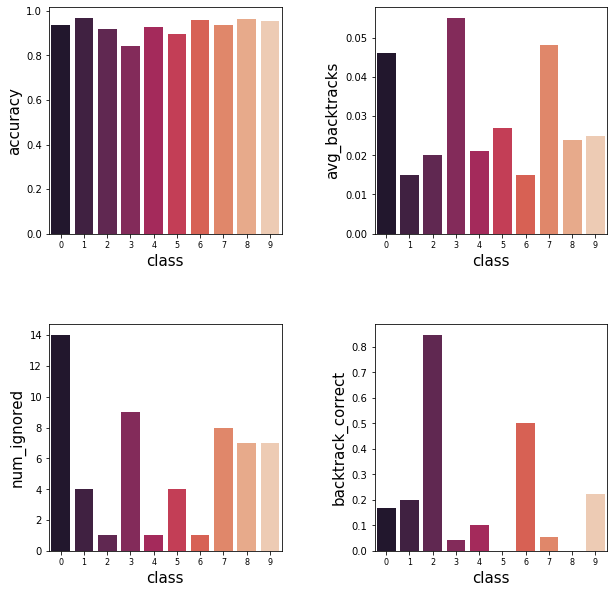

In [121]:
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(2, 2, 1)
sns.barplot(x='class', y='accuracy', data=stats, palette="rocket", ax=ax)
ax = fig.add_subplot(2, 2, 2)
sns.barplot(x='class', y='avg_backtracks', data=stats, palette="rocket", ax=ax)
ax = fig.add_subplot(2, 2, 3)
sns.barplot(x='class', y='num_ignored', data=stats, palette="rocket", ax=ax)
ax = fig.add_subplot(2, 2, 4)
sns.barplot(x='class', y='backtrack_correct', data=stats, palette="rocket", ax=ax)
plt.show()

## CIFAR100

In [92]:
df = pd.read_csv('output/cifar100_decision_tree_metrics.csv', sep='\t')
df[:10]

,Index,GT Class,Pred Class,Path,Path Probs,Num Nodes Explored,Node Backtracks
0,0,49,71,"['n00001740', 'n00001930']","[1.0, 0.0012]",5,"{'n00003553': 1, 'n00002684': 1, 'n00007846': 1}"
1,1,33,33,"['n00001740', 'n00002137']","[0.9887, 0.9995]",2,{}
2,2,72,93,"['n00001740', 'n00001930', 'n00002684', 'n0000...","[1.0, 0.9787, 0.9988, 0.9884, 0.9572, 0.4903, ...",9,{'n01661818': 1}
3,3,51,91,"['n00001740', 'n00001930', 'n00020827']","[0.9994, 0.8387, 0.7647]",3,{}
4,4,71,71,"['n00001740', 'n00001930']","[1.0, 0.9999]",2,{}
5,5,92,6,"['n00001740', 'n00001930', 'n00002684', 'n0000...","[1.0, 1.0, 1.0, 1.0, 0.7812, 0.9996, 0.9997, 0...",9,{}
6,6,15,15,"['n00001740', 'n00001930', 'n00002684', 'n0000...","[1.0, 0.9896, 0.9925, 0.8971, 0.9857, 0.9956, ...",10,{}
7,7,14,65,"['n00001740', 'n00001930', 'n00002684', 'n0000...","[0.9997, 0.9522, 0.9917, 0.9944, 0.9958, 0.481...",13,"{'n02159955': 1, 'n01767661': 1, 'n01905661': ..."
8,8,23,71,"['n00001740', 'n00001930']","[1.0, 0.9969]",2,{}
9,9,0,57,"['n00001740', 'n00001930', 'n00002684', 'n0000...","[1.0, 1.0, 1.0, 1.0, 0.9516]",5,{}


### Preprocessing

In [93]:
df['Node Backtracks'] = df['Node Backtracks'].apply(lambda x: ast.literal_eval(x))
df['Path'] = df['Path'].apply(lambda x: ast.literal_eval(x))
df['Path Probs'] = df['Path Probs'].apply(lambda x: ast.literal_eval(x))
df['Num Backtracks'] = df["Node Backtracks"].apply(lambda x: type(x))

## Per class stats

In [94]:
class_stats = {"class":[], "accuracy":[], "avg_path_len":[], "avg_backtracks":[], "target_path":[], "num_ignored":[],
               "incorrect_not_ignored":[], "backtrack_correct":[]}

In [95]:
for i in range(len(np.unique(df['GT Class']))):
    df['Num Backtracks'] = df["Node Backtracks"].apply(lambda x: len(x))
    class_df = df[df['GT Class']==i]
    class_stats["class"].append(i)
    class_stats["accuracy"].append(len(class_df[class_df['Pred Class']==i])/len(class_df))
    class_stats["avg_path_len"].append(np.mean(class_df["Num Nodes Explored"]))
    class_stats["avg_backtracks"].append(np.mean(class_df['Num Backtracks']))
    
    # find unique path
    gt_path = class_df[class_df['Pred Class']==i][class_df['Num Backtracks']==0]['Path']
    class_stats['target_path'].append(str(gt_path.iloc[0]))
    
    class_stats["num_ignored"].append(len(class_df[class_df['Pred Class']==-1]))
    class_stats["backtrack_correct"].append(len(class_df[class_df["Num Backtracks"]>0][class_df["Pred Class"] == i])/len(class_df[class_df["Num Backtracks"]>0]))
    
    incorrect = class_df[class_df['Pred Class']!=i]
    class_stats["incorrect_not_ignored"].append(len(incorrect[incorrect['Num Backtracks']!=0][incorrect["Index"]!=-1]))

In [96]:
stats = pd.DataFrame(class_stats)
stats[:10]

,class,accuracy,avg_path_len,avg_backtracks,target_path,num_ignored,incorrect_not_ignored,backtrack_correct
0,0,0.85,5.37,0.50,"['n00001740', 'n00001930', 'n00002684', 'n0000...",5,6,0.000000
1,1,0.70,7.98,0.92,"['n00001740', 'n00001930', 'n00002684', 'n0000...",6,12,0.333333
2,2,0.57,3.81,0.46,"['n00001740', 'n00001930', 'n00007846']",3,10,0.090909
3,3,0.27,8.24,0.68,"['n00001740', 'n00001930', 'n00002684', 'n0000...",6,18,0.142857
4,4,0.60,5.33,0.93,"['n00001740', 'n00001930', 'n00020827']",9,16,0.058824
5,5,0.67,7.24,0.50,"['n00001740', 'n00001930', 'n00002684', 'n0000...",2,7,0.300000
6,6,0.70,9.11,0.75,"['n00001740', 'n00001930', 'n00002684', 'n0000...",3,13,0.277778
7,7,0.68,8.91,1.04,"['n00001740', 'n00001930', 'n00002684', 'n0000...",9,17,0.000000
8,8,0.76,8.12,0.93,"['n00001740', 'n00001930', 'n00002684', 'n0000...",11,15,0.062500
9,9,0.66,7.89,1.05,"['n00001740', 'n00001930', 'n00002684', 'n0000...",6,17,0.000000


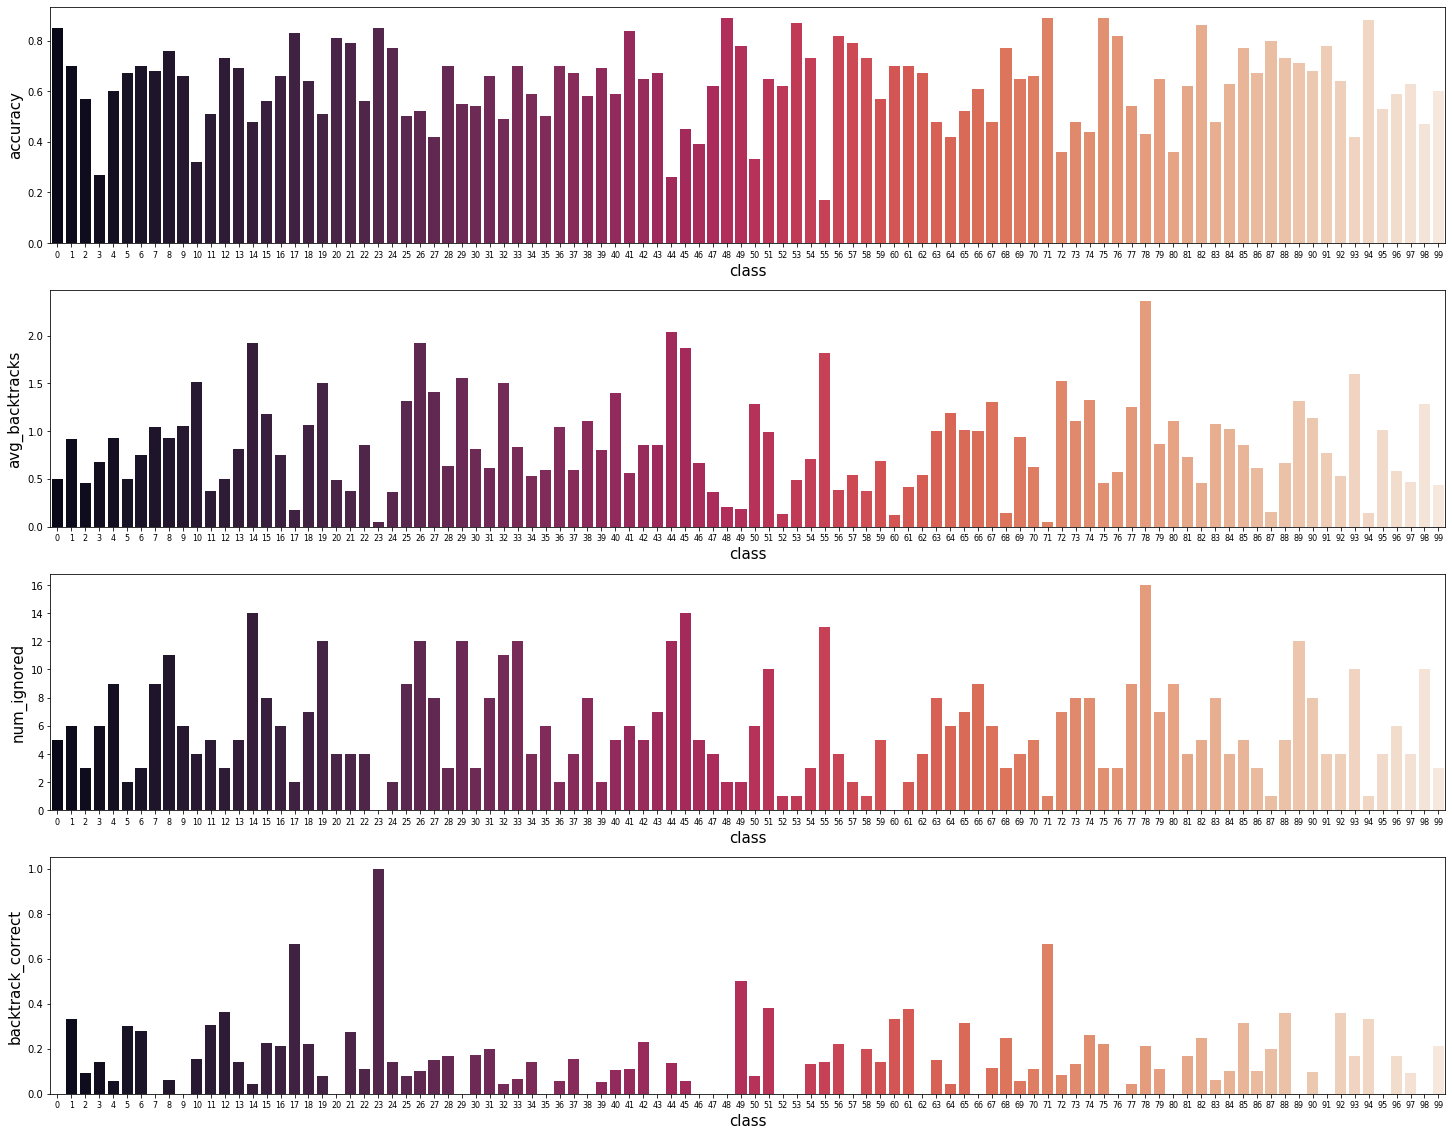

In [111]:
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 8 
mpl.rcParams['axes.labelsize'] = 15

fig = plt.figure(figsize=(25,20))
fig.subplots_adjust(hspace=0.2, wspace=0.1)
ax = fig.add_subplot(4, 1, 1)
sns.barplot(x='class', y='accuracy', data=stats, palette="rocket", ax=ax)
ax = fig.add_subplot(4, 1, 2)
sns.barplot(x='class', y='avg_backtracks', data=stats, palette="rocket", ax=ax)
ax = fig.add_subplot(4, 1, 3)
sns.barplot(x='class', y='num_ignored', data=stats, palette="rocket", ax=ax)
ax = fig.add_subplot(4, 1, 4)
sns.barplot(x='class', y='backtrack_correct', data=stats, palette="rocket", ax=ax)


plt.show()